In [1]:
# 读取news20训练数据集
# http://scikit-learn.org/stable/datasets/twenty_newsgroups.html
    
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), data_home='./')

In [2]:
# 样本数量 & target分类结果为 1 - 20
print(len(newsgroups_train.data))
print(newsgroups_train.target[:10])

11314
[ 7  4  4  1 14 16 13  3  2  4]


In [3]:
# text 预处理
# 去除符号 字母小写
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

data = []
for text in newsgroups_train.data:
    data.append(" ".join(tokenizer.tokenize(text.lower())))
    
print(data[0])

i was wondering if anyone out there could enlighten me on this car i saw the other day it was a 2 door sports car looked to be from the late 60s early 70s it was called a bricklin the doors were really small in addition the front bumper was separate from the rest of the body this is all i know if anyone can tellme a model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please e mail


In [8]:
# text 预处理
# 构建字典 将词专为index
# 然后截取固定长度作为输入 x

from tensorflow.contrib import learn
import numpy as np
max_document_length = 500
min_frequency = 2
vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length, min_frequency)
x = np.array(list(vocab_processor.fit_transform(newsgroups_train.data)))

print("vocabulary size: {:d}".format(len(vocab_processor.vocabulary_)))
print((x[5]))

vocabulary size: 39551
[  472   260    21  1285   191    15     0  1891     9    66  1697     7
  1000   389   593    20  1285    11    10   128    17   180     5  1386
 10239    30   290    40    13   181    12    79     7   241     1   437
    24  8001   141    36   600    43   955     4  1944  3889    24  3726
  3080     6   104  5797     3    75  3520    21   141   195 14663    26
     3   559    10    19    44   955   103    15  1155     6   104     1
   548  1531    26   405    20  1404     3   622   239  1215     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

In [9]:
# 分类结果 one-hot 处理

def one_hot_encode(x, length):
    encode_labels = np.zeros(shape=(len(x),length))
   
    for i in range(len(x)):
        label = x[i]
        a = np.zeros(length)
        a[label] = 1
        encode_labels[i] = a
    return encode_labels
y = one_hot_encode(newsgroups_train.target, len(newsgroups_train.target_names))
print(y[0])

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]


In [10]:
# data shuffle

np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(newsgroups_train.target)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

In [11]:
# 训练样本/测试样本 split

sample_rate = .1
dev_sample_index = -1 * int(sample_rate * float(len(newsgroups_train.target)))
x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]

print("train/test split: {:d}/{:d}".format(len(y_train), len(y_dev)))

train/test split: 10183/1131


In [12]:
# text CNN
# x = word2vec(x) 
# x[n] = maxpooling(CNN(x)), n = filter size (2,3,4)
# x = dropout(combine(x[n]))
# output = fullyconnect(x)

import tensorflow as tf
class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(
      self, sequence_length, num_classes, vocab_size,
      embedding_size, filter_sizes, num_filters):

        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Embedding layer
        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(self.embedded_chars_expanded, W, strides=[1, 1, 1, 1], padding="VALID", name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(h, ksize=[1, sequence_length - filter_size + 1, 1, 1], strides=[1, 1, 1, 1], padding='VALID', name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            W = tf.get_variable("W", shape=[num_filters_total, num_classes], initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # CalculateMean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses)

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [41]:
# text RNN
# x = word2vec(x) 
# x = last output of LSTM(x), layer = 1
# x = dropout(fullyconnect(x)) 
# output = fullyconnect(x)

num_layers = 1
def TextRNN(input_x, dropout_keep_prob, sequence_length, num_classes, vocab_size, embedding_size, rnnsize, fcsize):
    # Embedding layers
    w0 = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W")
    embedded_chars = tf.nn.embedding_lookup(w0, input_x)

#         lstm_cell = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(rnnsize)] * num_layers), output_keep_prob=self.dropout_keep_prob)
    lstm_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(rnnsize)] * num_layers)
    outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, embedded_chars, dtype=tf.float32)

    batch_size = tf.shape(outputs)[0]
    index = tf.range(0, batch_size) * sequence_length + (sequence_length - 1)
    # Indexing
    outputs = tf.gather(tf.reshape(outputs, [-1, rnnsize]), index)

    fc = tf.contrib.layers.fully_connected(outputs, fcsize, weights_initializer = tf.truncated_normal_initializer(stddev = 0.01), activation_fn=None)
    flat = tf.nn.dropout(fc, tf.to_float(dropout_keep_prob))
    # Final (unnormalized) scores and predictions
    w = tf.Variable(tf.random_normal([fcsize, num_classes], mean=0.0, stddev=0.1))
    b = tf.Variable(tf.random_normal([num_classes], mean=0.0, stddev=0.1))
    logits = tf.nn.xw_plus_b(flat, w, b, name="scores")
    return logits
        

In [42]:
# batch method

def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [63]:
# hyper parameters
embedding_dim = 100
filter_sizes = "3,4,5"
num_filters = 400
dropout_keep_prob = 0.8
rnnsize = 500
fcsize = 400
batch_size = 90
num_epochs = 5

learning_rate = 0.01

evaluate_every = 20

num_classes=y_train.shape[1]
sequence_length=x_train.shape[1]
vocabulary_len = len(vocab_processor.vocabulary_)

# build the network graph
train_graph = tf.Graph()
with train_graph.as_default():
    lr = tf.placeholder(tf.float32, name='LearingRate')
    dropout_keep = tf.placeholder(tf.float32, name='dropout')
    input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
    input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")

    logits = TextRNN(
        input_x,
        dropout_keep,
        sequence_length,
        num_classes,
        vocabulary_len,
        embedding_dim,
        rnnsize,
        fcsize)
    logits = tf.identity(logits, name='logits')


    # Loss and Optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=input_y))
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    train_op = optimizer.apply_gradients(capped_gradients)

    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(input_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    
    def train_step(x_batch, y_batch):
        """
        A single training step
        """
        feed_dict = {
          input_x: x_batch,
          input_y: y_batch,
          dropout_keep: dropout_keep_prob,
          lr: learning_rate
        }
        _, _loss, _accuracy = sess.run(
            [train_op, cost, accuracy],
            feed_dict)
        time_str = datetime.datetime.now().isoformat()
        print("{}:, loss {:g}, acc {:g}".format(time_str, _loss, _accuracy))

    def dev_step(x_batch, y_batch):
        """
        Evaluates model on a dev set
        """
        feed_dict = {
          input_x: x_batch,
          input_y: y_batch,
          dropout_keep: 1.0
        }
        _loss, _accuracy = sess.run(
            [cost, accuracy],
            feed_dict)
        time_str = datetime.datetime.now().isoformat()
        print("loss {:g}, acc {:g}".format(_loss, _accuracy))

/Users/bmy/anaconda/envs/py3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [64]:
# train

import datetime
    
batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    # Generate batches
    # Training loop. For each batch...
    step = 1
    for batch in batches:
        x_batch, y_batch = zip(*batch)
        
        print("batch {}".format(step))
        train_step(x_batch, y_batch)

        if step % evaluate_every == 0:
            print("\nEvaluation:")
            dev_step(x_dev, y_dev)
            print("")
        step = step + 1
        
    saver = tf.train.Saver(tf.global_variables(), max_to_keep=3)
    save_model_path = './trained_model'
    path = saver.save(sess, save_model_path)
    print("Saved model checkpoint to {}\n".format(path))
        

batch 1
2017-07-12T17:02:22.030725:, loss 2.98386, acc 0.0222222
batch 2
2017-07-12T17:02:37.524398:, loss 29.366, acc 0.0444444
batch 3
2017-07-12T17:02:52.579801:, loss 7.08152, acc 0.0444444
batch 4
2017-07-12T17:03:08.200479:, loss 9.62329, acc 0.1
batch 5
2017-07-12T17:03:23.486432:, loss 32.2848, acc 0.0777778
batch 6
2017-07-12T17:03:39.167325:, loss 8.16532, acc 0.0666667
batch 7
2017-07-12T17:03:54.477057:, loss 10.9306, acc 0.0777778
batch 8
2017-07-12T17:04:09.904485:, loss 11.6821, acc 0.0444444
batch 9
2017-07-12T17:04:25.377924:, loss 15.8342, acc 0.0444444
batch 10
2017-07-12T17:04:40.739510:, loss 9.68136, acc 0.0888889
batch 11
2017-07-12T17:04:56.700280:, loss 12.7359, acc 0.0444444
batch 12
2017-07-12T17:05:12.084763:, loss 8.58867, acc 0.0444444
batch 13
2017-07-12T17:05:27.814638:, loss 7.5895, acc 0.0222222
batch 14
2017-07-12T17:05:43.129664:, loss 7.73391, acc 0.0333333
batch 15
2017-07-12T17:05:58.732569:, loss 5.587, acc 0.0777778
batch 16
2017-07-12T17:06:14.

KeyboardInterrupt: 

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

(4, 4, 3, 40)
(240, 160)


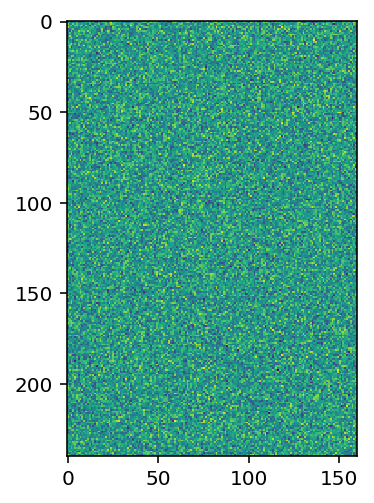

In [81]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def showPattern():
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        
        # Get Tensors from loaded model
        cnn1 = loaded_graph.get_tensor_by_name('cnn1:0')
        print(cnn1.shape)
        cnn1 = tf.reshape(cnn1, [48,40])
       
        w1 = cnn1.eval()
        plt.imshow(w1)
        
        cnn2 = loaded_graph.get_tensor_by_name('cnn2:0')
        cnn2 = tf.reshape(cnn2, [240,160])
        print(cnn2.shape)
        w2 = cnn2.eval()
        plt.imshow(w2)

        
        
showPattern()        

In [ ]:
def preparex(imgpath):
    x = np.empty([1, 32, 32, 3])
    img = mpimg.imread(imgpath)
    img = img[:, :, :3]
    x[0] = img
    return x

#  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def preparey(label):
    labels = helper._load_label_names()
    return one_hot_encode([labels.index(label)])
    
top_n_predictions = 3
    
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)

    # Get Tensors from loaded model
    loaded_x = loaded_graph.get_tensor_by_name('x:0')
    loaded_y = loaded_graph.get_tensor_by_name('y:0')
    loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
    
    x = preparex('./test7.png')
    y = preparey('airplane')
    # Print Random Samples
    result = sess.run(tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions), feed_dict={loaded_x: x, loaded_y: y, loaded_keep_prob: 1.0})
    helper.display_image_predictions(x, y, result)
    



## Why 50-70% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 70%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "dlnd_image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.